# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [4]:
%tensorflow_version 2.x
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.4.1'

#### Load Image Data

In [5]:
DATA_LIST = os.listdir('/content/drive/MyDrive/all/train')
DATASET_PATH  = '/content/drive/MyDrive/all/train'
TEST_DIR =  '/content/drive/MyDrive/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

In [6]:
print(DATA_LIST)

['covid', 'pneumonia_bac', 'pneumonia_vir', 'normal']


#### Generate Training and Validation Batches

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=False,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=False,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [8]:
#raise NotImplementedError("Build your model based on an architecture of your choice "
#                          "A sample model summary is shown below")

VGG16_MODEL = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
VGG16_MODEL.trainable=False
conv_layer = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=(224,224,3))
#conv_layer1 = tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu', input_shape=(224, 224, 3))
#conv_layer2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer1 = tf.keras.layers.Dense(256, activation='relu')
#dense_layer7 = tf.keras.layers.Dense(128, activation='relu')
#drop_layer = tf.keras.layers.Dropout(0.5)
dense_layer2 = tf.keras.layers.Dense(4, activation='softmax') #sigmoid is binary, softmax is multiclass

model = tf.keras.Sequential([
  VGG16_MODEL, conv_layer,
  flatten_layer,
  dense_layer1, dense_layer2
])

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005) #maybe different optimizer SGD, Nadam, Adam
model.compile(optimizer=opt,
                loss="categorical_crossentropy",
                metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 14,871,652
Trainable params: 156,964
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
print(train_batches[0][1].shape)
print(NUM_CLASSES)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(10, 4)
4


#### [5 points] Train Model

In [12]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# raise NotImplementedError("Use the model.fit function to train your network")

#IMAGE_SIZE    = (224, 224)
#NUM_CLASSES   = len(DATA_LIST)
#BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
#NUM_EPOCHS    = 100
#LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 
#raise NotImplementedError("Use the model.fit function to train your network")

# change model architecture (different pre-trained, more layers), change parameters (different epochs), 
# figure what architectures are designed for and try to implement / adding to it
# what the model is looking at
history = model.fit(train_batches, validation_data=valid_batches, epochs=150, 
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/150
21/21 [==============================] - 109s 4s/step - loss: 1.5188 - accuracy: 0.1580 - val_loss: 1.3909 - val_accuracy: 0.2000
Epoch 2/150
21/21 [==============================] - 7s 350ms/step - loss: 1.4067 - accuracy: 0.1554 - val_loss: 1.3566 - val_accuracy: 0.2000
Epoch 3/150
21/21 [==============================] - 7s 347ms/step - loss: 1.3476 - accuracy: 0.3416 - val_loss: 1.3368 - val_accuracy: 0.3400
Epoch 4/150
21/21 [==============================] - 7s 352ms/step - loss: 1.3291 - accuracy: 0.3234 - val_loss: 1.2476 - val_accuracy: 0.5000
Epoch 5/150
21/21 [==============================] - 7s 351ms/step - loss: 1.3660 - accuracy: 0.1669 - val_loss: 1.1974 - val_accuracy: 0.3800
Epoch 6/150
21/21 [==============================] - 7s 353ms/step - loss: 1.1884 - accuracy: 0.4912 - val_loss: 1.1476 - val_accuracy: 0.5400
Epoch 7/150
21/21 [==============================] - 7s 338ms/step - loss: 1.2394 - accuracy: 0.4933 - val_loss: 1.0908 - val_accuracy: 0.5000


#### [5 points] Plot Accuracy and Loss During Training

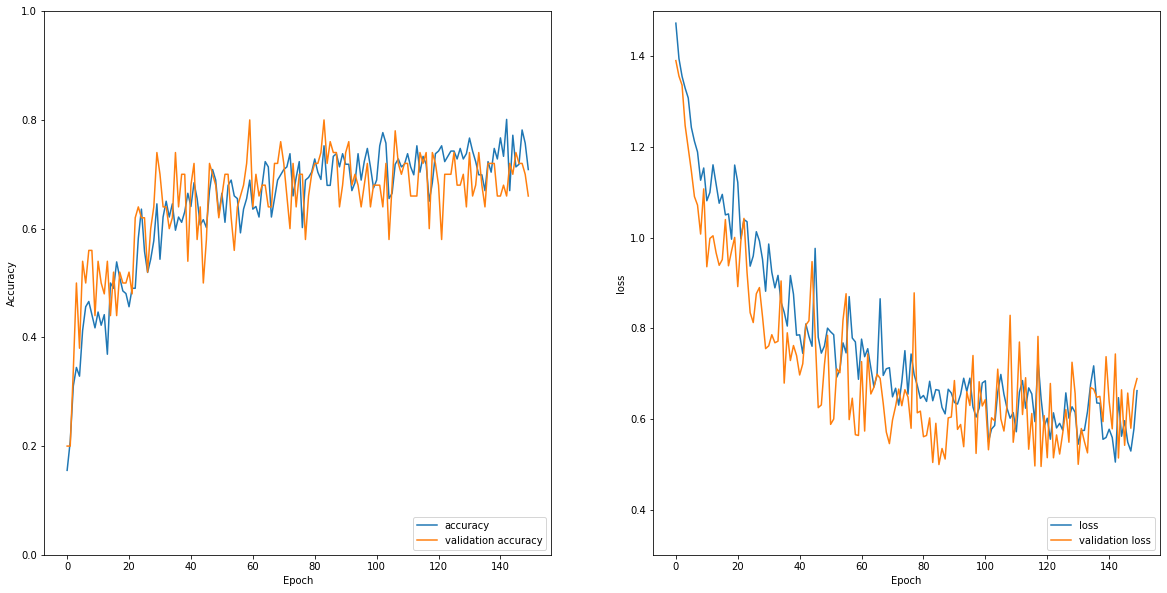

In [13]:
import matplotlib.pyplot as plt

# raise NotImplementedError("Plot the accuracy and the loss during training")
fig,axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'validation accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='lower right')

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label = 'validation loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('loss')
axs[1].set_ylim([0.3, 1.5])
axs[1].legend(loc='lower right')

#### Testing Model

In [14]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


36/36 [==============================] - 11s 282ms/step - loss: 1.0526 - accuracy: 0.5000
Test loss: 1.0525577068328857
Test accuracy: 0.5


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


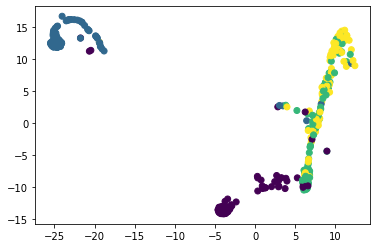

In [15]:
#from sklearn.manifold import TSNE

#intermediate_layer_model = models.Model(inputs=model.input,
#                                        outputs=model.get_layer('feature_dense').output)

#tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
#                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")

#raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                          "and plot the resulting 2D features of the four classes.")

import sklearn
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=dense_layer2.output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the two classes.")
# call predict on intermediate model pass generator and use that output to fit (transform) TSNE.

#data = [tsne_data_generator[i] for i in range(len(tsne_data_generator))]
color = [tsne_data_generator[i][1] for i in range(len(tsne_data_generator))]
tsne = intermediate_layer_model.predict(tsne_data_generator)
embedded = TSNE().fit_transform(tsne)
x = [i[0] for i in embedded]
y = [i[1] for i in embedded]
plt.scatter(x,y,c=color)

In [16]:
#raise NotImplementedError("Build your model based on an architecture of your choice "
#                          "A sample model summary is shown below")

#VGG16_MODEL = tf.keras.applications.VGG16(input_shape=(224,224,3),
#                                               include_top=False,
#                                               weights='imagenet')
ResNet152V2_MODEL = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

ResNet152V2_MODEL.trainable=False
conv_layer = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=(224,224,3))
#conv_layer1 = tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu', input_shape=(224, 224, 3))
#conv_layer2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer1 = tf.keras.layers.Dense(256, activation='relu')
#dense_layer7 = tf.keras.layers.Dense(128, activation='relu')
#drop_layer = tf.keras.layers.Dropout(0.5)
dense_layer2 = tf.keras.layers.Dense(4, activation='softmax') #sigmoid is binary, softmax is multiclass

model = tf.keras.Sequential([
  ResNet152V2_MODEL, conv_layer,
  flatten_layer,
  dense_layer1, dense_layer2
])

234553344/234545216 [==============================] - 2s 0us/step


In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005) #maybe different optimizer SGD, Nadam, Adam
model.compile(optimizer=opt,
                loss="categorical_crossentropy",
                metrics=['accuracy'])

In [18]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# raise NotImplementedError("Use the model.fit function to train your network")

#IMAGE_SIZE    = (224, 224)
#NUM_CLASSES   = len(DATA_LIST)
#BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
#NUM_EPOCHS    = 100
#LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 
#raise NotImplementedError("Use the model.fit function to train your network")

# change model architecture (different pre-trained, more layers), change parameters (different epochs), 
# figure what architectures are designed for and try to implement / adding to it
# what the model is looking at
history = model.fit(train_batches, validation_data=valid_batches, epochs=150, 
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/150
21/21 [==============================] - 18s 502ms/step - loss: 2.2074 - accuracy: 0.0830 - val_loss: 1.5652 - val_accuracy: 0.2800
Epoch 2/150
21/21 [==============================] - 8s 368ms/step - loss: 1.4520 - accuracy: 0.3193 - val_loss: 1.3435 - val_accuracy: 0.2800
Epoch 3/150
21/21 [==============================] - 8s 361ms/step - loss: 1.3372 - accuracy: 0.3050 - val_loss: 1.2675 - val_accuracy: 0.3400
Epoch 4/150
21/21 [==============================] - 8s 358ms/step - loss: 1.1993 - accuracy: 0.4561 - val_loss: 1.1592 - val_accuracy: 0.4400
Epoch 5/150
21/21 [==============================] - 8s 356ms/step - loss: 1.1809 - accuracy: 0.4859 - val_loss: 1.0847 - val_accuracy: 0.4400
Epoch 6/150
21/21 [==============================] - 8s 360ms/step - loss: 1.0414 - accuracy: 0.4375 - val_loss: 0.9929 - val_accuracy: 0.5000
Epoch 7/150
21/21 [==============================] - 8s 358ms/step - loss: 1.1368 - accuracy: 0.5453 - val_loss: 0.9996 - val_accuracy: 0.520

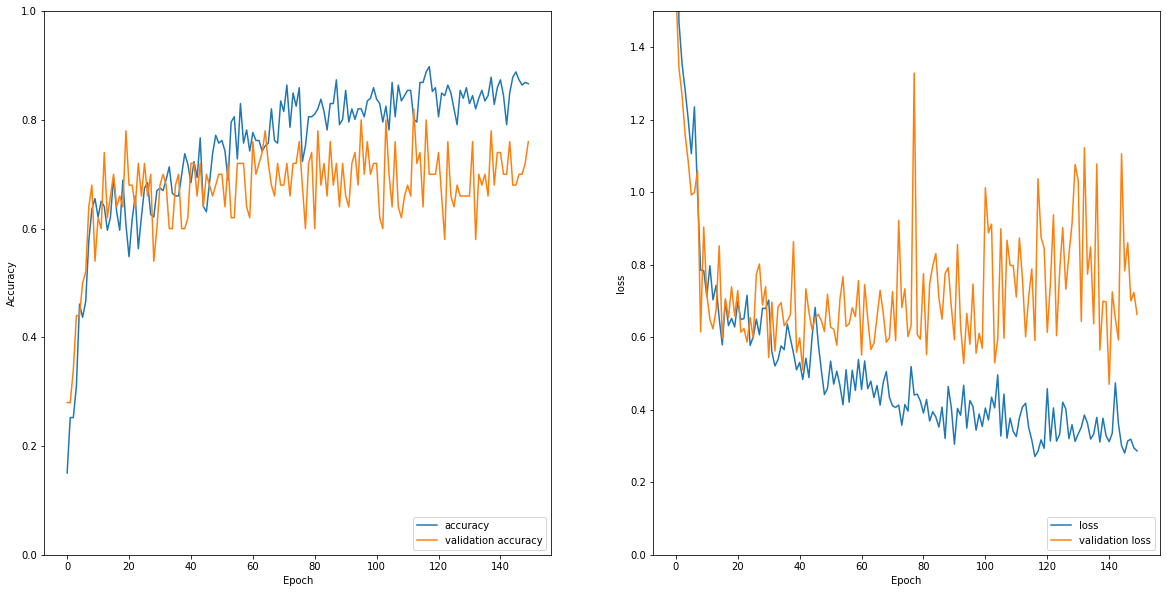

In [19]:
import matplotlib.pyplot as plt

# raise NotImplementedError("Plot the accuracy and the loss during training")
fig,axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'validation accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='lower right')

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label = 'validation loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('loss')
axs[1].set_ylim([0, 1.5])
axs[1].legend(loc='lower right')

In [20]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


36/36 [==============================] - 2s 38ms/step - loss: 0.8006 - accuracy: 0.6389
Test loss: 0.800611138343811
Test accuracy: 0.6388888955116272


Found 270 images belonging to 4 classes.


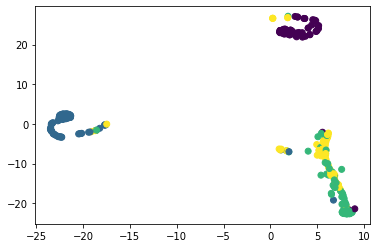

In [21]:
import sklearn
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=dense_layer2.output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the two classes.")
# call predict on intermediate model pass generator and use that output to fit (transform) TSNE.

#data = [tsne_data_generator[i] for i in range(len(tsne_data_generator))]
color = [tsne_data_generator[i][1] for i in range(len(tsne_data_generator))]
tsne = intermediate_layer_model.predict(tsne_data_generator)
embedded = TSNE().fit_transform(tsne)
x = [i[0] for i in embedded]
y = [i[1] for i in embedded]
plt.scatter(x,y,c=color)

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->